In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.interpolate import RBFInterpolator

Load in calibration images

In [4]:
buffer = 0
img = cv2.imread('limage.png')
width = img.shape[1]
img = img[:, :width//2 - buffer]

Defines function to display image

In [5]:
def disp(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)

Defines function to automatically detect as many corners as possible

In [6]:
def getCorners(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, quality = cv2.goodFeaturesToTrackWithQuality(gimg, maxCorners=200, qualityLevel=0.10, minDistance=7, mask=None)
    return corners

Defines function to display corners

In [7]:
def displayCorners(img, corners, nums=True):
    _img = img.copy()
    for i in range(len(corners)):
        point = corners[i]
        cv2.circle(_img,(int(point[0][0]),int(point[0][1])),3,(0,0,255),-1)
        if nums:
            cv2.putText(_img,str(i),(int(point[0][0]),int(point[0][1])-2),0,0.5,(0,0,255))

    disp(_img)

Define Radial Basis Function

In [8]:
def getRBF(actual_corners, ideal_corners, additional_points):
    print(ideal_corners.shape)
    print(actual_corners.shape)

    filter = actual_corners[:,0,0] != -1.

    ideal_pair = np.squeeze(ideal_corners, axis=1)[filter]
    print(ideal_pair.dtype, ideal_pair.shape)

    actual_x = actual_corners[filter][:,0,0]
    print(actual_x.dtype, actual_x.shape)

    actual_y = actual_corners[filter][:,0,1]

    if additional_points is not None:
        actual_additional_points = additional_points[0]
        ideal_additional_points = additional_points[1]

        ideal_pair = np.concatenate((ideal_pair, ideal_additional_points))
        print("ideal", ideal_pair[-2:])

        actual_x = np.concatenate((actual_x, actual_additional_points[:,0]))
        print("actual x", actual_x[-2:])

        actual_y = np.concatenate((actual_y, actual_additional_points[:,1]))
        print("actual y", actual_y[-2:])

    rbf_x = RBFInterpolator(ideal_pair, actual_x)
    rbf_y = RBFInterpolator(ideal_pair, actual_y)

    return rbf_x, rbf_y, filter

Map image according coeficients

In [70]:
def undistort(img, new_shape, actual_corners, ideal_corners, additional_points=None):
    old_shape = img.shape[:2]
    fun_x, fun_y, filter = getRBF(actual_corners, ideal_corners, additional_points)

    x_off = -30*scale #old_shape[0] - new_shape[0]
    y_off = 0 #old_shape[1] - new_shape[1]

    map_x = np.zeros(new_shape, dtype=np.float32)
    map_y = np.zeros(new_shape, dtype=np.float32)
    for i in range(map_x.shape[0]):
        for j in range(map_x.shape[1]):
            map_x[i,j] = fun_x(np.array([[j+x_off, i+y_off]]))
            map_y[i,j] = fun_y(np.array([[j+x_off, i+y_off]]))

    return map_x, map_y, filter

Find potential corners

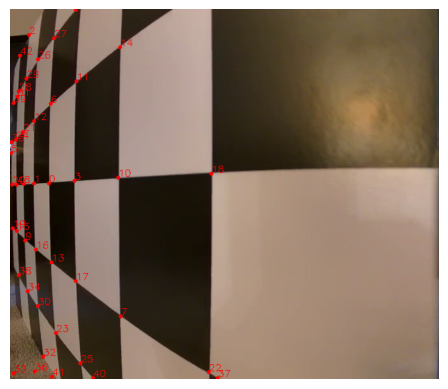

In [10]:
grid_height, grid_width = 7, 9

corn = getCorners(img)
displayCorners(img, corn)

Manually remove incorrect corners

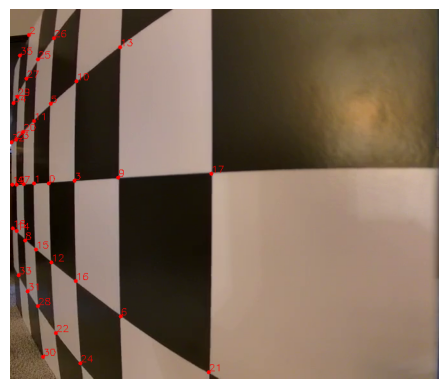

In [11]:
remove = [37, 33, 36, 40, 5, 28, 41,43]

mask = [True]*len(corn)
for r in remove:
    mask[r] = False
corn_n = corn[mask]

displayCorners(img, corn_n)

Lineup the indexes of the actual corners

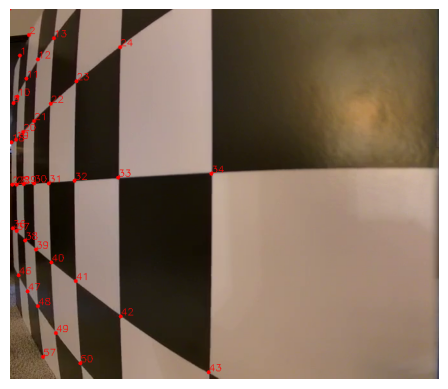

In [12]:
actual_corners = np.zeros((grid_height*grid_width, 1, 2))-1

map = {35:1, 2:2,
       34:9, 29:10, 27:11, 25:12, 26:13,
       32:18, 23:19, 20:20, 11:21, 5:22, 10:23, 13:24,
       19:27, 4:28, 7:29, 1:30, 0:31, 3:32, 9:33, 17:34,
       18:36, 14:37, 8:38, 15:39, 12:40, 16:41, 6:42, 21:43,
       33:46, 31:47, 28:48, 22:49, 24:50,
       30:57}

assert (sorted(list(map.keys())) == list(range(len(corn_n)))), "map does not map all detected corner points"

for i in range(len(corn_n)):
    actual_corners[map[i]] = corn_n[i]

displayCorners(img, actual_corners)

Add Aditional Corners

(576, 668, 3)


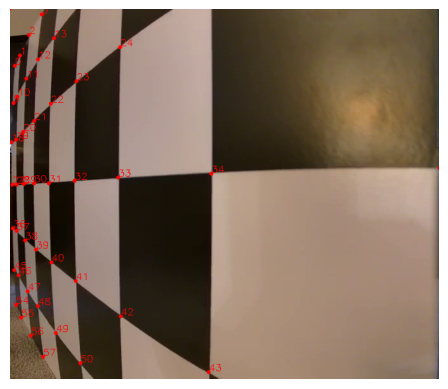

In [13]:
print(img.shape)
actual_corners[0] = np.array([[7, 88]])
actual_corners[3] = np.array([[49, 8]])
actual_corners[35] = np.array([[668, 247]])
actual_corners[45] = np.array([[6, 406]])
actual_corners[54] = np.array([[9, 460]])
actual_corners[55] = np.array([[17, 480]])
actual_corners[56] = np.array([[32, 508]])

displayCorners(img, actual_corners, True)

Create ideal corner points

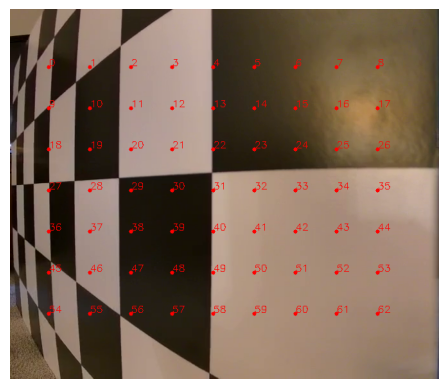

In [14]:
block_len = 64
height, width, _ = img.shape
ideal_corners = np.zeros((grid_height*grid_width, 1, 2))
start = np.array([60, 90])

for i in range(grid_height):
    for j in range(grid_width):
        ideal_corners[grid_width*i + j, 0] = start
        start[0] += block_len
    start[1] += block_len
    start[0] -= block_len*grid_width

displayCorners(img, ideal_corners)

Add Additional Points

In [15]:
additional_points = None

Get Callibration Matrix

In [28]:
map_x, map_y, filter = undistort(img, img.shape[:2], actual_corners, ideal_corners, additional_points)
map = np.stack((map_x, map_y), axis=2)

(63, 1, 2)
(63, 1, 2)
float64 (43, 2)
float64 (43,)
ideal [[572. 240.]
 [572. 330.]]
actual x [668. 668.]
actual y [  0. 576.]


Display Undistorted Image

(576, 668, 3)


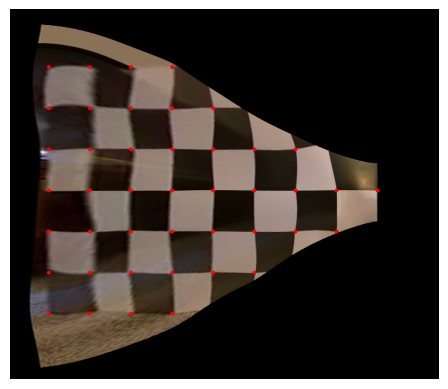

In [29]:
per = cv2.remap(img, map, None, cv2.INTER_CUBIC)
print(per.shape)
displayCorners(per, ideal_corners[filter], False)

Decide to add additional points

(576, 668, 3)
[[572. 282.]]
[[668. 247.]]
[[[668.   0.]
  [668. 576.]]

 [[572. 240.]
  [572. 330.]]]


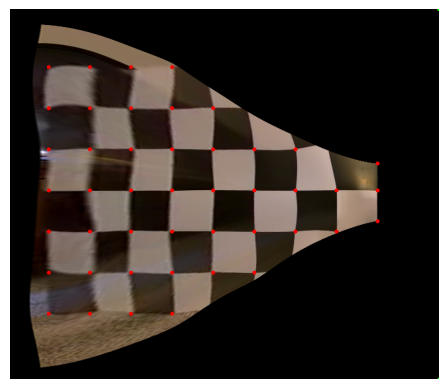

In [22]:
ideal_point1 = [572, 240]
actual_point1 = [668, 0]
ideal_point2 = [572, 330]
print(img.shape)
actual_point2 = [668, img.shape[0]]
print(ideal_corners[35])
print(actual_corners[35])
_img = per.copy()

_img = cv2.circle(_img, ideal_point1, 3, (0,0,255), -1)
_img = cv2.circle(_img, actual_point1, 3, (0,255,0), -1)

_img = cv2.circle(_img, ideal_point2, 3, (0,0,255), -1)
_img = cv2.circle(_img, actual_point2, 3, (0,255,0), -1)
displayCorners(_img, ideal_corners[filter], False)

additional_points = np.array([[actual_point1, actual_point2], [ideal_point1, ideal_point2]], dtype=np.float64)
print(additional_points)

Improve resolution of rectifies image

In [71]:
scale = 3
scaled_additional_points = additional_points.copy()
scaled_additional_points[1] *= scale
#print((scale*ideal_corners)[~filter])
#displayCorners(per, (scale*ideal_corners)[filter], False)
map_x, map_y, filter = undistort(img, scale * np.array(img.shape[:2]), actual_corners, scale*ideal_corners, scaled_additional_points)
map = np.stack((map_x, map_y), axis=2)

(63, 1, 2)
(63, 1, 2)
float64 (43, 2)
float64 (43,)
ideal [[1716.  720.]
 [1716.  990.]]
actual x [668. 668.]
actual y [  0. 576.]


(1728, 2004, 3)


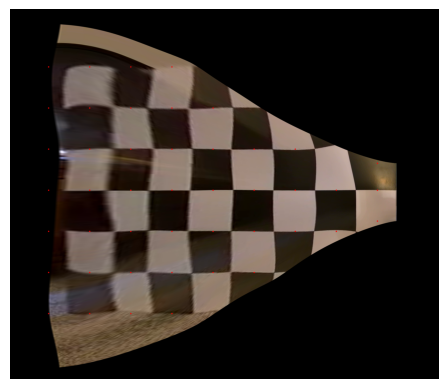

In [72]:
per = cv2.remap(img, map, None, cv2.INTER_CUBIC)

ideal_point1 = scale*additional_points[1,0].astype(int)
ideal_point2 = scale*additional_points[1,1].astype(int)
_img = per.copy()
_img = cv2.circle(_img, ideal_point1, 3, (0,0,255), -1)
_img = cv2.circle(_img, ideal_point2, 3, (0,0,255), -1)

print(per.shape)
displayCorners(_img, (scale*ideal_corners)[filter], False)

Save Callibration

In [68]:
np.save('./calibration_np/left_calibration.npy', map)